In [60]:
import torch
import torch.nn as nn
import numpy as np
import os
import sys
import cv2
from PIL import Image
import easydict
sys.path.append('../Whatiswrong')
import Extract
import utils
import torch.nn.functional as F
import easydict
import torchvision

In [5]:
import torchvision.models as models

In [ ]:
class Basemodel(nn.Module):
    def __init__(self, opt):
        super(Basemodel, self).__init__()
        self.encoder = Resnet_EFIFSTR(with_lstm=True)
        self.decoder = 
        
    def forward(self, img)

In [30]:
def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)

def conv1x1(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class ResnetBlock(nn.Module):

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(ResnetBlock, self).__init__()
        self.conv1 = conv1x1(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

class Resnet_encoder(nn.Module):
    def __init__(self, n_group=1):
        super(Resnet_encoder, self).__init__()
        self.n_group= n_group
        
        in_channels=3
        self.layer0 = nn.Sequential(nn.Conv2d(in_channels, 32, kernel_size=(3,3), stride=1, padding=1, bias=False),
                                   nn.BatchNorm2d(32),
                                   nn.ReLU(inplace=True))
        self.inplanes = 32
        self.layer1 = self._make_layer(32, 3, [2,2])
        self.layer2 = self._make_layer(64, 4, [2,2])
        self.layer3 = self._make_layer(128, 6, [2,1])
        self.layer4 = self._make_layer(256, 6, [1,1])
        self.layer5 = self._make_layer(512, 3, [1,1])
        
        self.rnn = nn.LSTM(512, int(512/2), num_layers=2, batch_first=True)
        self.out_planes = 2 * 256

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
        
    def _make_layer(self, planes, blocks, stride):
        downsample = None
        if stride !=[1,1] or self.inplanes != planes:
            downsample = nn.Sequential(conv1x1(self.inplanes, planes, stride),
                                      nn.BatchNorm2d(planes))
            
        layers = []
        layers.append(ResnetBlock(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for _ in range(1, blocks):
            layers.append(ResnetBlock(self.inplanes, planes))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x0 = self.layer0(x)
        x1 = self.layer1(x0)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)
        x5 = self.layer5(x4)
        feature_map = x5
        feature_map_list = [x1, x2, x3, x4, x5]
        
        batch_size, channels, feature_h, feature_w = feature_map.shape
        cnn_feat = F.max_pool2d(feature_map, (feature_h, 1))
        cnn_feat = cnn_feat.permute(0, 3, 1, 2).squeeze(3)

        _, holistic_feature = self.rnn(cnn_feat)
        return feature_map_list, holistic_feature
                   

In [44]:
class Decoder(nn.Module): 
    
    def __init__(self, num_classes, fmap_dim, enc_dim, dec_dim, att_dim, opt): #att dim = 512
        super(Decoder, self).__init__()
        self.opt = opt
        self.attention_unit = Attention_unit(fmap_dim, dec_dim, att_dim )
        self.input_embedding = nn.Embedding(self.opt.num_classes+1, enc_dim) # including <BOS>
#         self.lstm = nn.LSTMCell(enc_dim, dec_dim)
        self.lstm = nn.LSTM(enc_dim, dec_dim, num_layers = 2, batch_first=True)
        
        self.fc = nn.Linear(dec_dim + fmap_dim, self.opt.num_classes +2 ) # including <BOS>,<EOS>
        
        
    def forward(self, feature_map, holistic_feature, Input, is_train):
        x, target, length = Input
        batch_size, channel, height, width = feature_map.shape

        logits = torch.zeros(batch_size, opt.max_length+1, opt.num_classes+2).fill_(opt.num_classes) ### last class : <EOS>
        masks = torch.zeros(batch_size, opt.max_length+1, height, width )
        input_label = torch.zeros(batch_size, 1, dtype= torch.long).fill_(self.opt.num_classes) #### the second last is used as the <BOS>, 

        input_emb = self.input_embedding(input_label)
        output, states =  self.lstm(input_emb, holistic_feature)
        glimpse, mask = self.attention_unit(feature_map, output)
        glimpse = glimpse.permute(0, 2, 1, 3).squeeze(3)
        logit = self.fc(torch.cat([output, glimpse], axis=2))
        logits[:, [0], :] = logit
        masks[:,[0], :, : ] = mask
        
        if is_train:
            for i in range(self.opt.max_length):
                input_label = target[:, [i]]
                input_emb = self.input_embedding(input_label)
                output, states = self.lstm(input_emb, states)
                glimpse, mask = self.attention_unit(feature_map, output)
                glimpse = glimpse.permute(0, 2, 1, 3).squeeze(3)
                logit = self.fc(torch.cat([output, glimpse], axis=2))
                logits[:, [i+1], :] = logit
                masks[:,[i+1], :, : ] = mask
                
        else:
            pred = torch.argmax(logit, dim=-1)
            for i in range(1, self.opt.max_length):
                input_emb = self.input_embedding(pred)
                output, states = self.lstm(input_emb, states)
                glimpse, mask = self.attention_unit(feature_map, output)
                glimpse = glimpse.permute(0, 2, 1, 3).squeeze(3)
                logit = self.fc(torch.cat([output, glimpse], axis=2))
                loogits[:, [i], :] = logit 
                masks[:,[i+1], :, : ] = mask
                pred = torch.argmax(torch.softmax(logit, axis=-1), -1)
        
        return logits, masks
        
        
class Attention_unit(nn.Module):
    
    def __init__(self, fmap_dim, lstm_dim, attn_dim):
        super(Attention_unit, self).__init__()
        self.fmap_dim = fmap_dim
        self.lstm_dim = lstm_dim
        self.e_lstm_conv = nn.Conv2d(lstm_dim, attn_dim, kernel_size=1)
        self.e_Fmap_conv = nn.Conv2d(fmap_dim, attn_dim, kernel_size=3, padding=1)
        self.a_conv = nn.Conv2d(attn_dim, 1, kernel_size=1)
        
    def forward(self, fmap, hidden_state):
        batch_size, channel, height, width = fmap.shape
        hidden_state = hidden_state.permute(0, 2, 1).unsqueeze(3)
        e_lstm_conv_ =  self.e_lstm_conv(hidden_state)
        e_lstm_conv_ = e_lstm_conv_.repeat(1, 1, height, width)
        e_fmap_conv_ = self.e_Fmap_conv(fmap)
#         print('e_lstm_conv res : ', e_lstm_conv_.shape)
#         print('e_fmap_conv res : ', e_fmap_conv_.shape)
        e = torch.tanh_(e_lstm_conv_ + e_fmap_conv_)
        a_conv_ = self.a_conv(e)  
        a = F.softmax(a_conv_.reshape((batch_size, -1)), dim = -1)
        mask = a.reshape((batch_size, 1, height, width))
        broad_casted = (fmap * mask).reshape(batch_size, channel, -1)
        glimpse = torch.sum(broad_casted, dim= -1).reshape((batch_size, channel, 1, 1))
#         print('glimpse shape : ', glimpse.shape)
        return glimpse, mask

In [38]:
class Generator(nn.Module):
    def __init__(self, opt):
        super(Generator, self).__init__()
        self.generator_1 = nn.Linear(int(opt.img_h/2) * int(opt.img_w/2), 16 * 16)
        self.generator_2 = nn.Linear(int(opt.img_h/4) * int(opt.img_w/4), 8 * 8)
        self.generator_3 = nn.Linear(int(opt.img_h/8) * int(opt.img_w/4), 4 * 4)
        self.font_embedding = nn.Embedding(opt.num_fonts, 128)

    def generate_glimpse(self, fmap_s1, masks):
        _, fmap_s1_c, fmap_s1_h, fmap_s1_w = fmap_s1.shape
        mask_s1 = F.interpolate(masks, size = (fmap_s1_h, fmap_s1_w), mode='bilinear', align_corners=False)
        mask_s1 = mask_s1.repeat(1, fmap_s1_c, 1, 1)
        fmap_s1.unsqueeze_(1)  #[N, 1, c, 24, 80]
        fmap_s1 = fmap_s1.repeat(1, self.seq_len, 1, 1, 1).reshape((self.batch_size * self.seq_len, fmap_s1_c, fmap_s1_h, fmap_s1_w))
        glimpse_s1 = torch.mul(mask_s1, fmap_s1)
        
        #reshape
        glimpse_s1 = glimpse_s1.reshape((self.batch_size * self.seq_len, fmap_s1_c, fmap_s1_h * fmap_s1,w))
        
        return glimpse_s1, fmap_s1_c
    
    
    def forward(self, feature_map_list, masks):
        
        self.batch_size,  self.seq_len,  self.height,  self.width = masks.shape 
        masks = masks.reshape((batch_size * seq_len, 1, height, width))
        
        glimpse_s1, fmap_s1_c = generate_glimpse(feature_map_list[0], masks)  # feature_map_list[0] shape  # 24 * 80
        glimpse_s2, fmap_s2_c = generate_glimpse(feature_map_list[1], masks)   # 12 * 40
        glimpse_s3, fmap_s3_c = generate_glimpse(feature_map_list[2], masks)   # 6 * 40
        _, feature_c, feature_h, feature_w = fmap_last.shape       

        fmap_last = feature_map_list[-1] # 6 * 40
        
#         ### fmap s3
#         mask_s3 = masks.repeat(1,fmap_s1_c, 1,1)
#         fmap_s3.unsqueeze_(1) #  after unsqueeze -> [N, 1, c, 6, 40]
#         fmap_s3 = fmap_s3.repeat(1, seq_len, 1, 1, 1).reshape((batch_size * seq_len, fmap_s3_c, fmap_s3_h, fmap_s3_w))
#         glimpse_s3 = torch.mul(mask_s3, fmap_s3)
        
#         ## fmap s2
#         mask_s2 = F.interpolate(masks, size = (fmap_s2_h, fmap_s2_w), mode='bilinear', align_corners=False)
#         fmap_s2.unsqueeze_(1)  #[N, 1, c, 12, 40]
#         fmap_s2 = fmap_s2.repeat(1, seq_len, 1, 1, 1).reshape((batch_size * seq_len, fmap_s2_c, fmap_s2_h, fmap_s2_w))
#         glimpse_s2 = torch.mul(mask_s2, fmap_s2)

        gen_1 = self.generator_1(glimpse_s1)
        gen_2 = self.generator_2(glimpse_s2)
        gen_3 = self.generator_3(glimpse_s3)
        
        gen_1 = gen_1.reshape((self.batch_size * self.seq_len , fmap_s1_c, 16, 16))
        gen_2 = gen_2.reshape((self.batch_size * self.seq_len , fmap_s2_c, 8, 8))
        gen_3 = gen_3.reshape((self.batch_size * self.seq_len , fmap_s1_c, 4, 4))
        
        embedding_ids = torch.randint(low=0, high= 104, size=(self.batch_size * self.seq_len))
        font_embedded = self.font_embedding(embedding_ids)
        


In [120]:
import tensorflow as tf

In [123]:
embeddings = tf.compat.v1.get_variable("Embedding", [325, 1, 1, 128], tf.float32, tf.random_normal_initializer(stddev=0.01), trainable = True)

In [124]:
embeddings_ids = tf.random.uniform([2], minval = 0, maxval = 325, dtype= tf.int64)

In [125]:
res = tf.gather(embeddings , embeddings_ids)

In [127]:
res[0].shape

TensorShape([1, 1, 128])

In [132]:
emb = nn.Embedding(104, 128)

In [136]:
idx = torch.randint(0, 104, size = (20,))

In [138]:
emb_res = emb(idx)

In [140]:
emb_res.reshape((20, 1, 1, 128))

tensor([[[[-0.5062, -1.0473, -0.6756,  ...,  0.1441, -0.1520,  0.4853]]],


        [[[-1.1960, -0.1352, -1.1072,  ..., -0.4492, -0.8839, -0.7102]]],


        [[[-1.1994,  0.1184,  0.8018,  ...,  1.3211, -1.6681,  2.1872]]],


        ...,


        [[[ 0.3782,  0.5842,  0.2902,  ..., -0.0369, -0.5360,  1.3972]]],


        [[[ 1.3536,  1.3173, -1.6219,  ...,  1.2961, -0.8625, -0.2497]]],


        [[[-1.8092,  0.2794, -0.2372,  ..., -1.5593,  0.9193,  0.6989]]]],
       grad_fn=<ViewBackward>)

In [83]:
opt = easydict.EasyDict({'max_length' : 10,
                        'num_classes' : 10 ,
                        'num_fonts' : 104})

In [68]:
glimpse = torch.mul(torch.FloatTensor(16, 3, 20, 20).uniform_(-1,1), torch.FloatTensor(16,3,20,20).uniform_(-1, 1))

In [71]:
glimpse_ = glimpse.reshape((16,3, 20*20))

In [72]:
res = nn.Linear(20*20, 16*16)(glimpse_)

In [73]:
res.shape

torch.Size([16, 3, 256])

In [54]:
batch_size = 3
length = opt.max_length
inputx = torch.LongTensor(list(range(length))*batch_size).reshape((batch_size, length))
targetx = torch.LongTensor(list(range(length))*batch_size).reshape((batch_size, length))
lengthx = torch.IntTensor([length]*batch_size)
x = [inputx, targetx, lengthx]

In [39]:
targetx

tensor([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]])

In [12]:
feature_map = torch.FloatTensor(batch_size, 512, 65, 65).uniform_(-1.0, 1.0)

In [13]:
holistic_feature = [torch.FloatTensor(2, batch_size, 64).uniform_(-1.0, 1.0), torch.FloatTensor(2, batch_size, 64).uniform_(-1.0, 1.0)]

- decoder

In [45]:
decoder = Decoder(num_classes=10, fmap_dim = 512, enc_dim= 32, dec_dim= 64, att_dim=128, opt = opt )

In [48]:
logit, masks = decoder(feature_map, holistic_feature, x, is_train=True)

In [50]:
masks.shape

torch.Size([3, 11, 65, 65])

- encoder

In [32]:
encoder = Resnet_encoder()

In [33]:
image = torch.FloatTensor(1, 3, 48, 160)

In [34]:
fmap_list, holistic = encoder(image)

In [37]:
fmap_list[1].shape

torch.Size([1, 64, 12, 40])

In [311]:
holistic[0].shape

torch.Size([2, 1, 256])

In [322]:
holistic[1].shape

torch.Size([2, 1, 256])

- lstm

In [312]:
lstm = nn.LSTM(512, 256, num_layers = 2, batch_first=True)

In [313]:
lstm_input = torch.FloatTensor(1,35,512)

In [314]:
one_input = lstm_input[:, :1, :]

In [329]:
one_input.shape

torch.Size([1, 1, 512])

In [315]:
output, hiddens = lstm(one_input, holistic)

In [51]:
output.shape

NameError: name 'output' is not defined

In [246]:
hiddens[0].shape

torch.Size([8, 1, 256])

In [247]:
hiddens[0].transpose(0,1).contiguous().view(1, -1, 512).transpose(0,1).shape

torch.Size([4, 1, 512])

- font 

In [82]:
fonts = np.load('./data/glyphs_ko_104.npy')

In [101]:
from tensorflow.keras.preprocessing.image import array_to_img

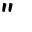

In [112]:
array_to_img(((fonts[2447*100 + 3].reshape((32, 32, 1))+1.0) * 127.5).astype(np.uint8))